In [45]:
%load_ext autoreload
%autoreload 2
import sys
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt
from os.path import join as oj
import pandas as pd
import pickle as pkl
import models
import util
import os
import config
from config import ATTR_TO_INDEX
import viz
import scipy.stats
from tqdm import tqdm
import figs
import matplotlib.image as mpimg
import seaborn as sns
import data
import transects
import sklearn.metrics
CELEB_IMS_DIR = '../data/celeba-hq/ims/'
CELEB_ANNO_DIR = '../data/celeba-hq/Anno/'


# load and merge all the data
print('loading labels...')
df = data.load_ids()
labs, labs_full = data.load_labs()
for k in labs.keys():
    df[k] = labs[k].values
for k in labs_full.keys():
    df[k] = labs_full[k].values
df['fname_id'] = df['fname_final'].str.slice(stop=-4)
print('done loading!')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
loading labels...
done loading!


# load latents + get associated labs

In [46]:
DIR_ORIG = '../data/celeba-hq/ims/'
# IM_NUMS = np.arange(1, 1301)

DIRS_GEN = '../data_processed/celeba-hq/'
reg = 0.1
DIR_GEN = oj(DIRS_GEN, f'generated_images_{reg}')

In [47]:
fname_nps = [f for f in sorted(os.listdir(DIR_GEN)) if 'npy' in f]
fname_ids = np.array([f[:-4] for f in fname_nps])

# trim df to only have the relevant ids
df = df.set_index('fname_id')
df = df.loc[fname_ids]

In [48]:
latents = np.array([np.load(oj(DIR_GEN, f)) for f in fname_nps])

In [49]:
# load the linear model in latent space
print('shape', latents.shape)
coefs, intercepts = transects.get_directions()
coefs = np.array(coefs).squeeze()
intercepts = np.array(intercepts)

shape (3714, 18, 512)


/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator Ridge from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/ubuntu/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator LinearSVC from version 0.21.3 when using version 0.22.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


**calculate all distances**

In [37]:
def get_lat(latents):
    lat = latents.mean(axis=1) # match in style space
    # lat = latents.reshape(latents.shape[0], -1) # match in extended style space
    return lat
    
def get_dists(lat):
    '''Get distances
    '''
    # calculate distances: (points, points)
#     dists = sklearn.metrics.pairwise_distances(lat, metric='cosine') # cosine dist
    dists = sklearn.metrics.pairwise_distances(lat, metric='l2') # cosine dist
    # sns.clustermap(dists)
    dists[np.eye(dists.shape[0]).astype(bool)] = 1e3 # don't pick same point
    # plt.imshow(dists)
    # dists_min = np.argmin(dists, axis=1)
    return dists

def join_vecs(preds, lats, weights, discretize=False):
    '''Joins preds and lat with equal weight, optionally weighting preds
    preds
        (N_images, N_attr)
    weights: np.ndarray
        length (N_attr), containing weight for each attr of the predictions
    '''
    lats_norm = (lats - lats.mean(axis=0)) / lats.std(axis=0)
    preds_norm = (preds - preds.mean(axis=0)) / preds.std(axis=0)
    if discretize:
        preds_norm = (preds_norm > 0).astype(int)
    preds_norm = (preds - preds.mean(axis=0)) / preds.std(axis=0)
    preds_norm = preds_norm * weights
    
    vecs = np.hstack((preds_norm, lats_norm))
    return vecs

lats = get_lat(latents)
preds = lats @ coefs.T + intercepts.T
weights = np.zeros(preds.shape[1])
# weights[ATTR_TO_INDEX['skin-color']] = 1e2
vecs = join_vecs(preds, lats, weights)
dists = get_dists(vecs)

In [38]:
print(ATTR_TO_INDEX)

{'hair-length': 0, 'age': 1, 'gender': 2, 'skin-color': 3, 'facial-hair': 4, 'makeup': 5, 'smiling': 6, 'eyeglasses': 7, 'earrings': 8}


## show matches for an im

00001


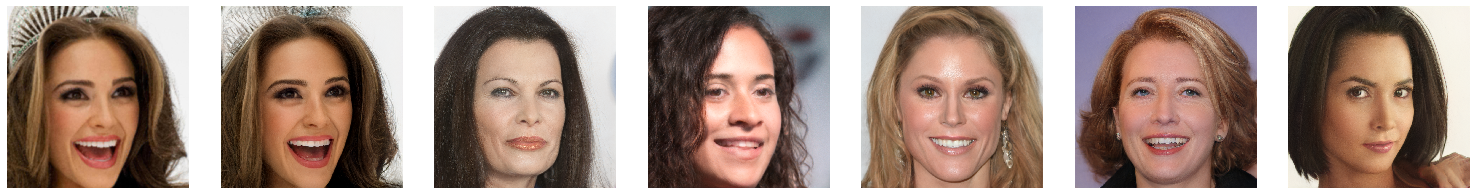

[  38  271 1468 ... 1144 1451    0] ['00039' '00272' '01469' ... '01145' '01452' '00001']
00002


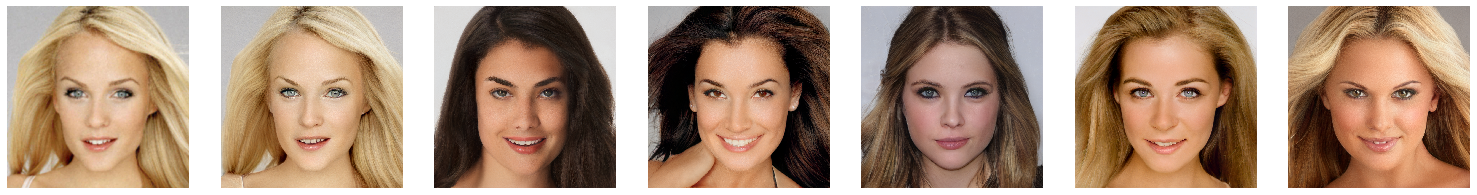

[3345  109 2797 ... 1827 3151    1] ['03346' '00110' '02798' ... '01828' '03152' '00002']
00003


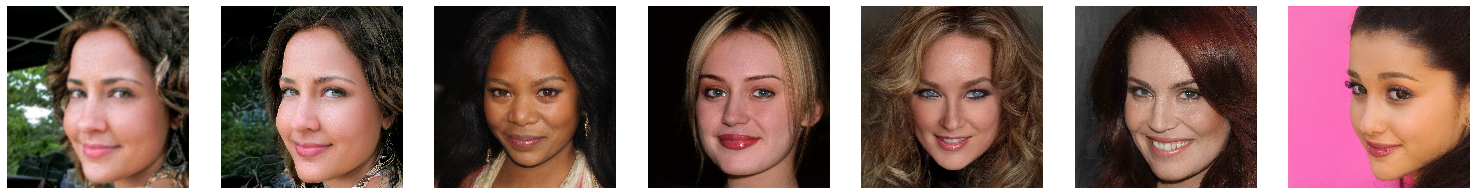

[ 692 1721  407 ...  475 3151    2] ['00693' '01722' '00408' ... '00476' '03152' '00003']
00004


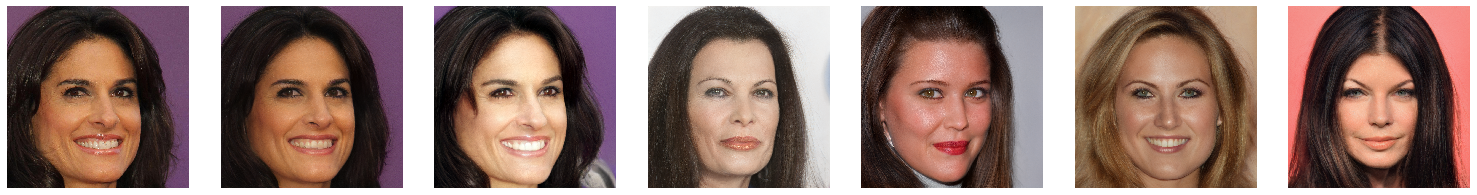

[3230   38 1724 ... 1451 1144    3] ['03231' '00039' '01725' ... '01452' '01145' '00004']
00005


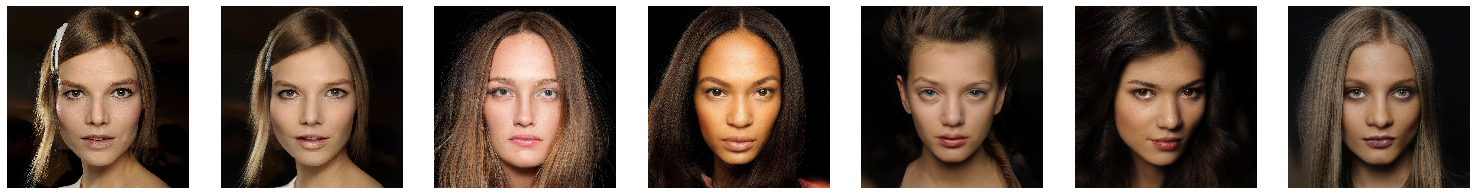

[1715  103 2619 ... 3165 3151    4] ['01716' '00104' '02620' ... '03166' '03152' '00005']
00006


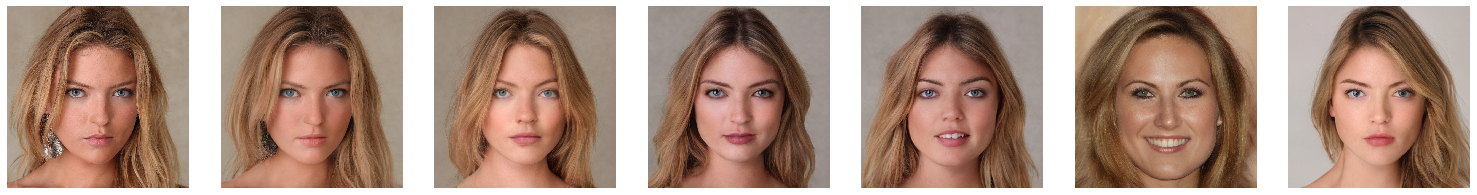

[ 412   66 2228 ... 1144 3151    5] ['00413' '00067' '02229' ... '01145' '03152' '00006']
00007


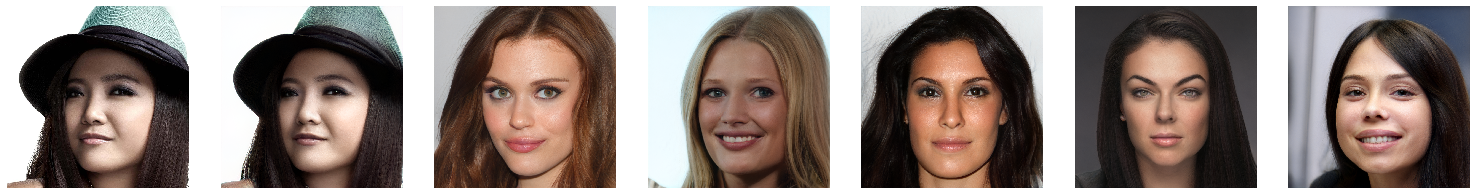

[ 579 1060 2386 ... 2369 3151    6] ['00580' '01061' '02387' ... '02370' '03152' '00007']
00008


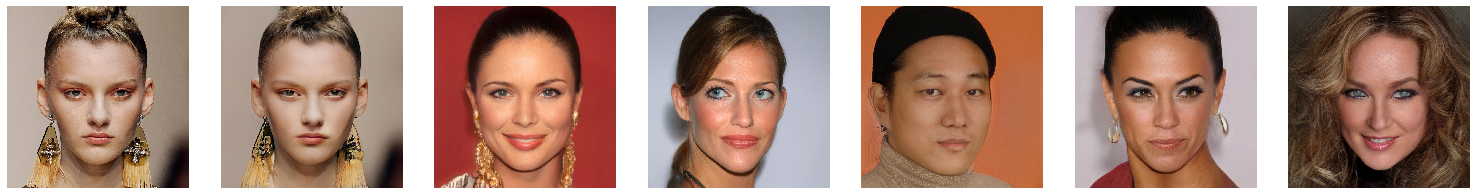

[3569 2486  430 ... 3151 1727    7] ['03570' '02487' '00431' ... '03152' '01728' '00008']


In [67]:
def calc_matches(im_idx, dists, fname_ids):
    '''
    dists: np.array
        only contains possible matches
    '''
    closest_matches = np.argsort(dists) #dists[im_num - 1])
    return closest_matches, fname_ids[closest_matches]

def show_matches(dists, DIR_ORIG, DIR_GEN, fname_ids, im_nums=range(60, 70)):
    # pick the image
    for im_num in im_nums:
        R, C = 1, 7
        plt.figure(figsize=(C * 2, R * 2))

        plt.subplot(R, C, 1)
        im_orig = mpimg.imread(oj(DIR_ORIG, f'{im_num:05}.jpg'))
        util.imshow(im_orig)
        plt.title('original im', fontsize=10)

        plt.subplot(R, C, 2)
        im_rec = mpimg.imread(oj(DIR_GEN, f'{im_num:05}.png'))
        util.imshow(im_rec)
        plt.title('reconstruction', fontsize=10)

    #     print(dists[im_num - 1][closest_matches])
        plt.subplot(R, C, 3)
        plt.title('closest matches...', fontsize=10)
        for i in range(C - 2):
            plt.subplot(R, C, i + 3)
            matched_num = closest_matches[i] + 1
            im = mpimg.imread(oj(DIR_GEN, f'{matched_num:05}.png'))
            util.imshow(im)
        plt.show()

for im_idx in range(8):
    # if all images are calculated, then this is just 5-char string of im_idx + 1
    fname_id = fname_ids[im_idx] 
    print(fname_id)
    im_fname = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    dists_im = dists[im_idx]
    closest_matches, closest_matches_fnames = calc_matches(im_idx, dists_im, fname_ids)
    
    
    # load images
    N_MATCHES_TO_PLOT = 5
    im_orig = mpimg.imread(oj(DIR_ORIG, f'{fname_id}.jpg'))
    im_rec = mpimg.imread(oj(DIR_GEN, f'{fname_id}.png'))
    im_matches = [mpimg.imread(oj(DIR_GEN, f'{fname_match}.png'))
                  for fname_match in closest_matches_fnames[:N_MATCHES_TO_PLOT]]
    
    # plt images
    util.plot_row([im_orig, im_rec] + im_matches)
    plt.show()
    # print(closest_matches, closest_matches_fnames)
# show_matches(dists, DIR_ORIG, DIR_GEN, im_nums=range(5, 10))